In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
from tqdm import tqdm
from sklearn.linear_model import LogisticRegression 
from sklearn.svm import SVC  
from sklearn.model_selection import GridSearchCV
from sklearn import metrics
from sklearn.metrics import roc_curve, auc , f1_score
from sklearn.metrics import confusion_matrix

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_curve, roc_auc_score
from imblearn.under_sampling import RandomUnderSampler
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import GradientBoostingClassifier
from imblearn.combine import SMOTETomek
from imblearn.combine import SMOTEENN

#For Evaluating models.
import eli5
from eli5.sklearn import PermutationImportance



In [2]:
#import processed data
combined = pd.read_csv('~/Documents/GitHub/medicare-fraud-detection/data/processed/combined.csv', low_memory=False)
partb = pd.read_csv('~/Documents/GitHub/medicare-fraud-detection/data/processed/partb.csv', low_memory=False)
partd = pd.read_csv('~/Documents/GitHub/medicare-fraud-detection/data/processed/partd.csv', low_memory=False)

In [3]:
#making targets binary
partb.TARGET = partb.TARGET.map({'FRAUD': 1, 'NOT_FRAUD': 0}).astype(int)
partd.TARGET = partd.TARGET.map({'FRAUD': 1, 'NOT_FRAUD': 0}).astype(int)
combined.TARGET = combined.TARGET.map({'FRAUD': 1, 'NOT_FRAUD': 0}).astype(int)

In [4]:
#split data set into features and label
# partb dataset
X_partb = partb.drop(columns=['TARGET'], axis=1)
y_partb = partb.TARGET

#partd dataset
X_partd = partd.drop(columns=['TARGET'], axis=1)
y_partd = partd.TARGET

#dmepos dataset

#combined dataset
X_combined = combined.drop(columns=['TARGET'], axis=1)
y_combined = combined.TARGET

In [5]:
#downsampling
rus1 = RandomUnderSampler(random_state=42)
X_partb, y_partb = rus1.fit_resample(X_partb, y_partb)

rus2 = RandomUnderSampler(random_state=42)
X_partd, y_partd = rus2.fit_resample(X_partd, y_partd)



rus4 = RandomUnderSampler(random_state=42)
X_combined, y_combined = rus4.fit_resample(X_combined, y_combined)

In [6]:
#split data set into train and test set
X_train_b, X_test_b, y_train_b, y_test_b = train_test_split(X_partb, y_partb, test_size=0.2, random_state=0)
X_train_d, X_test_d, y_train_d, y_test_d = train_test_split(X_partd, y_partd, test_size=0.2, random_state=0)

X_train_combined, X_test_combined, y_train_combined, y_test_combined = train_test_split(X_combined, y_combined, test_size=0.2, random_state=0)

In [7]:
#scale the data
partb_feature_names = X_partb.columns.to_list()

X_partb_scaler = StandardScaler()
X_partb_scaled = X_partb_scaler.fit_transform(X_train_b) #Fit/Transform to the training data

X_train_b = pd.DataFrame(X_partb_scaled, columns=partb_feature_names)
X_test_b = pd.DataFrame(X_partb_scaler.transform(X_test_b), columns=partb_feature_names) #Transform the test set with fitted scaler.

In [8]:
partd_feature_names = X_partd.columns.to_list()

X_partd_scaler = StandardScaler()
X_partd_scaled = X_partd_scaler.fit_transform(X_train_d)

X_train_d = pd.DataFrame(X_partd_scaled, columns=partd_feature_names)
X_test_d = pd.DataFrame(X_partd_scaler.transform(X_test_d), columns=partd_feature_names)


In [9]:
combined_feature_names = X_combined.columns.to_list()

X_combined_scaler = StandardScaler()
X_combined_scaled = X_combined_scaler.fit_transform(X_train_combined)

X_train_combined = pd.DataFrame(X_combined_scaled, columns=combined_feature_names)
X_test_combined = pd.DataFrame(X_combined_scaler.transform(X_test_combined), columns = combined_feature_names)

In [10]:
#Now we apply logistic regression
logreg_b = LogisticRegression(max_iter=10**4, penalty='l1', solver='saga')
logreg_d = LogisticRegression(max_iter=10**4, penalty='l1', solver='saga')

logreg_combined = LogisticRegression(max_iter=10**4, penalty='l1', solver='saga')

In [11]:
param_grid_logreg = {  
    'penalty': ['l1', 'l2', 'elasticnet'],
    'C': [.01, .05, .001],
}

In [12]:
grid_tree_logreg_b = RandomizedSearchCV(logreg_b, 
                                  param_grid_logreg, 
                                  cv=5,
                                  n_jobs=-1,
                                  scoring='f1')

grid_tree_logreg_d = RandomizedSearchCV(logreg_d, 
                                  param_grid_logreg, 
                                  cv=5,
                                  n_jobs=-1,
                                  scoring='f1')



grid_tree_logreg_combined = RandomizedSearchCV(logreg_combined, 
                                  param_grid_logreg, 
                                  cv=5,
                                  n_jobs=-1,
                                  scoring='f1')

In [13]:
#fit the models to the training data
grid_tree_logreg_b.fit(X_train_b, y_train_b)
grid_tree_logreg_d.fit(X_train_d, y_train_d)

grid_tree_logreg_combined.fit(X_train_combined, y_train_combined)

RandomizedSearchCV(cv=5,
                   estimator=LogisticRegression(max_iter=10000, penalty='l1',
                                                solver='saga'),
                   n_jobs=-1,
                   param_distributions={'C': [0.01, 0.05, 0.001],
                                        'penalty': ['l1', 'l2', 'elasticnet']},
                   scoring='f1')

In [14]:
grid_tree_logreg_combined.best_params_

{'penalty': 'l2', 'C': 0.05}

In [15]:
#predict on the test set
y_pred_b = grid_tree_logreg_b.predict(X_test_b)
y_pred_d = grid_tree_logreg_d.predict(X_test_d)

y_pred_combined = grid_tree_logreg_combined.predict(X_test_combined)

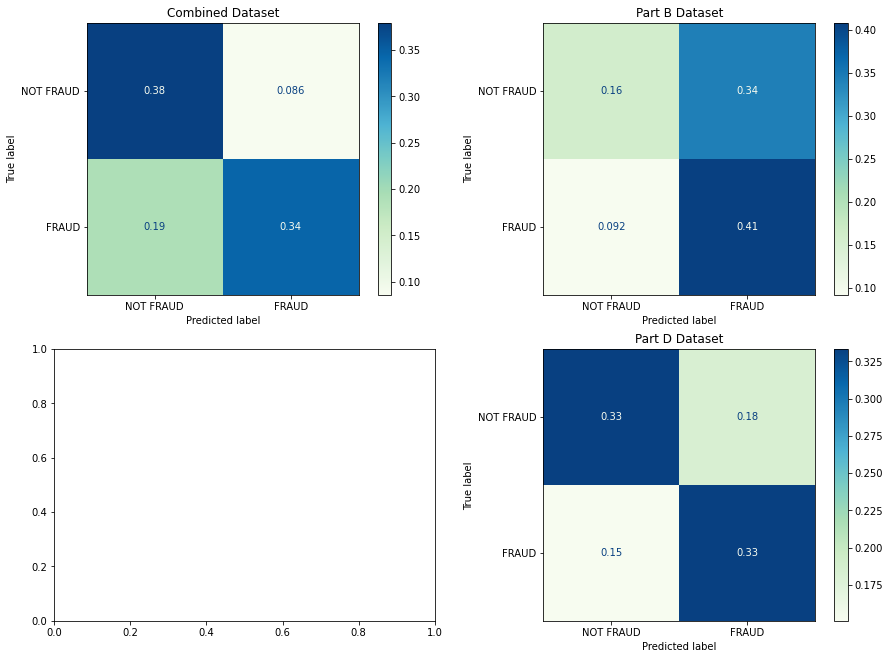

In [16]:
#evaluate performance
fig, ax = plt.subplots(2,2)
fig.set_size_inches(15, 11)


confusion_matrix_combined = metrics.plot_confusion_matrix(grid_tree_logreg_combined, X_test_combined, y_test_combined, cmap= "GnBu", ax = ax[0,0], normalize='all')
ax[0,0].set_title('Combined Dataset')
ax[0,0].set_xticklabels(['NOT FRAUD','FRAUD'])
ax[0,0].set_yticklabels(['NOT FRAUD','FRAUD'])

confusion_matrix_partb = metrics.plot_confusion_matrix(grid_tree_logreg_b, X_test_b, y_test_b, cmap= "GnBu", ax = ax[0,1], normalize='all')
ax[0,1].set_title('Part B Dataset')
ax[0,1].set_xticklabels(['NOT FRAUD','FRAUD'])
ax[0,1].set_yticklabels(['NOT FRAUD','FRAUD'])


confusion_matrix_partd = metrics.plot_confusion_matrix(grid_tree_logreg_d, X_test_d, y_test_d, cmap= "GnBu", ax = ax[1,1], normalize='all')
ax[1,1].set_title('Part D Dataset')
ax[1,1].set_xticklabels(['NOT FRAUD','FRAUD'])
ax[1,1].set_yticklabels(['NOT FRAUD','FRAUD'])




fig.savefig('logreg_confusion.png')

We can see from the ROC curves below that the Combined dataset performs the best.


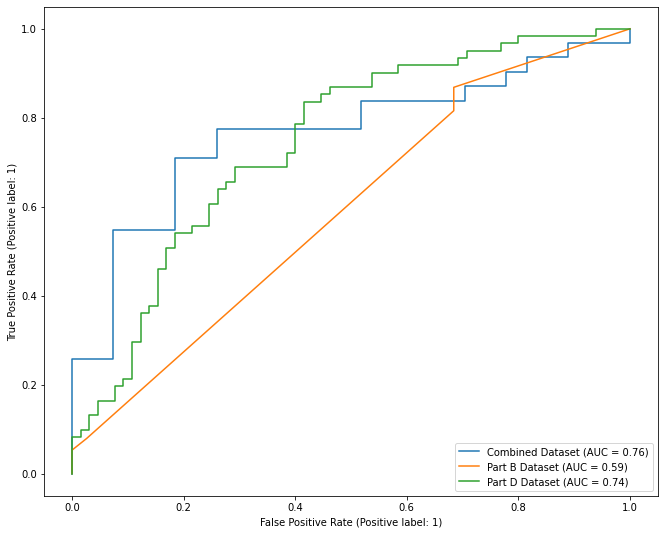

In [17]:
#plot ROC
ROC_combined = metrics.plot_roc_curve(grid_tree_logreg_combined, X_test_combined, y_test_combined, name='Combined Dataset')
ROC_partb = metrics.plot_roc_curve(grid_tree_logreg_b, X_test_b, y_test_b, name='Part B Dataset', ax=ROC_combined.ax_)
ROC_partd = metrics.plot_roc_curve(grid_tree_logreg_d, X_test_d, y_test_d, name="Part D Dataset", ax = ROC_combined.ax_)

ROC_combined.figure_.set_size_inches(11,9)
print("We can see from the ROC curves below that the Combined dataset performs the best.")
plt.savefig('logreg_ROC.png')

In [18]:
#features importance using eli5
log_perm = PermutationImportance(grid_tree_logreg_combined, random_state=1).fit(X_train_combined, y_train_combined)

print('Logistic Regression Feature Importances:')
eli5.show_weights(log_perm, feature_names=combined_feature_names)

Logistic Regression Feature Importances:


Weight,Feature
0.0286 ± 0.0364,Tot_Benes_median_x
0.0270 ± 0.0126,Rndrng_Prvdr_Type_Podiatry
0.0267 ± 0.0325,Rndrng_Prvdr_Type_Internal Medicine
0.0176 ± 0.0298,Rndrng_Prvdr_Gndr_M
0.0145 ± 0.0247,Tot_Benes_median_y
0.0142 ± 0.0152,Rndrng_Prvdr_Type_Neurology
0.0138 ± 0.0072,Rndrng_Prvdr_Type_Cardiology
0.0124 ± 0.0186,Tot_30day_Fills_median
0.0114 ± 0.0052,Rndrng_Prvdr_Type_Obstetrics & Gynecology
0.0099 ± 0.0111,Rndrng_Prvdr_Type_Hematology-Oncology


In [19]:
#features B importance using eli5
log_perm_b = PermutationImportance(grid_tree_logreg_b, random_state=1).fit(X_train_b, y_train_b)

print('Logistic Regression Feature Importances part B: ')
eli5.show_weights(log_perm_b, feature_names=partb_feature_names)

Logistic Regression Feature Importances part B: 


Weight,Feature
0.0975 ± 0.0286,Rndrng_Prvdr_Gndr_M
0 ± 0.0000,Rndrng_Prvdr_Type_Anesthesiology Assistant
0 ± 0.0000,Rndrng_Prvdr_Type_Audiologist
0 ± 0.0000,Rndrng_Prvdr_Type_Cardiac Surgery
0 ± 0.0000,Rndrng_Prvdr_Type_Cardiology
0 ± 0.0000,Rndrng_Prvdr_Type_Certified Clinical Nurse Specialist
0 ± 0.0000,Rndrng_Prvdr_Type_Certified Nurse Midwife
0 ± 0.0000,Rndrng_Prvdr_Type_Certified Registered Nurse Anesthetist (CRNA)
0 ± 0.0000,Rndrng_Prvdr_Type_Chiropractic
0 ± 0.0000,Rndrng_Prvdr_Type_Geriatric Medicine


<AxesSubplot:>

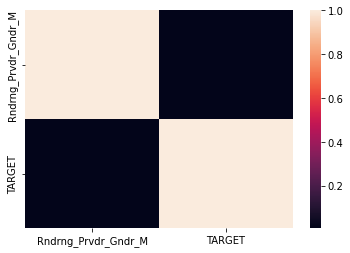

In [20]:
temp = partb[['Rndrng_Prvdr_Gndr_M', 'TARGET']]
sns.heatmap(temp.corr())

In [21]:
#f1 score
print(f1_score(y_test_combined, y_pred_combined))
print(f1_score(y_test_b, y_pred_b))
print(f1_score(y_test_d, y_pred_d))

0.7142857142857142
0.6526315789473685
0.6666666666666666


In [22]:
#try random forest 
rf_b = RandomForestClassifier(n_jobs=-1)
rf_d = RandomForestClassifier(n_jobs=-1)
rf_combined = RandomForestClassifier(n_jobs=-1)

In [23]:
param_grid_rf = {  
    'n_estimators': list(range(1,2000)),
    'criterion': ['gini','entropy'],
    'max_depth': list(range(1,50)),
    'min_samples_leaf': list(range(1,50,1)),
}

In [24]:
tree_rf_b = RandomizedSearchCV(rf_b, 
                                  param_grid_rf, 
                                  cv=5,
                                  verbose=1,
                                  scoring='f1')

tree_rf_d = RandomizedSearchCV(rf_d, 
                                  param_grid_rf, 
                                  cv=5,
                                  n_jobs=-1,
                                  scoring='f1')



tree_rf_combined = RandomizedSearchCV(rf_combined, 
                                  param_grid_rf, 
                                  cv=5,
                                  n_jobs=-1,
                                  scoring='f1')

In [25]:
tree_rf_b.fit(X_train_b, y_train_b)
tree_rf_d.fit(X_train_d, y_train_d)

tree_rf_combined.fit(X_train_combined, y_train_combined)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


RandomizedSearchCV(cv=5, estimator=RandomForestClassifier(n_jobs=-1), n_jobs=-1,
                   param_distributions={'criterion': ['gini', 'entropy'],
                                        'max_depth': [1, 2, 3, 4, 5, 6, 7, 8, 9,
                                                      10, 11, 12, 13, 14, 15,
                                                      16, 17, 18, 19, 20, 21,
                                                      22, 23, 24, 25, 26, 27,
                                                      28, 29, 30, ...],
                                        'min_samples_leaf': [1, 2, 3, 4, 5, 6,
                                                             7, 8, 9, 10, 11,
                                                             12, 13, 14, 15, 16,
                                                             17, 18, 19, 20, 21,
                                                             22, 23, 24, 25, 26,
                                                          

In [26]:
#f1 score for random forest
y_pred_forest_combined = tree_rf_combined.predict(X_test_combined)
print(f1_score(y_test_combined, y_pred_forest_combined))

0.7500000000000001


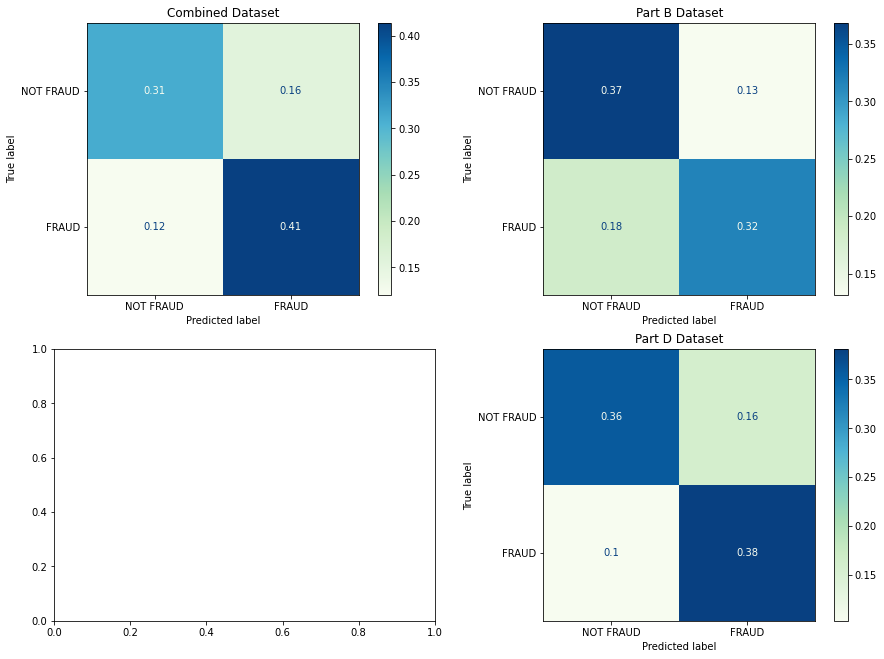

In [27]:
#evaluate performance of random forest
fig, ax = plt.subplots(2,2)
fig.set_size_inches(15, 11)


confusion_matrix_combined = metrics.plot_confusion_matrix(tree_rf_combined, X_test_combined, y_test_combined, cmap= "GnBu", ax = ax[0,0], normalize='all')
ax[0,0].set_title('Combined Dataset')
ax[0,0].set_xticklabels(['NOT FRAUD','FRAUD'])
ax[0,0].set_yticklabels(['NOT FRAUD','FRAUD'])

confusion_matrix_partb = metrics.plot_confusion_matrix(tree_rf_b, X_test_b, y_test_b, cmap= "GnBu", ax = ax[0,1], normalize='all')
ax[0,1].set_title('Part B Dataset')
ax[0,1].set_xticklabels(['NOT FRAUD','FRAUD'])
ax[0,1].set_yticklabels(['NOT FRAUD','FRAUD'])


confusion_matrix_partd = metrics.plot_confusion_matrix(tree_rf_d, X_test_d, y_test_d, cmap= "GnBu", ax = ax[1,1], normalize='all')
ax[1,1].set_title('Part D Dataset')
ax[1,1].set_xticklabels(['NOT FRAUD','FRAUD'])
ax[1,1].set_yticklabels(['NOT FRAUD','FRAUD'])




fig.savefig('forest_confusion.png')

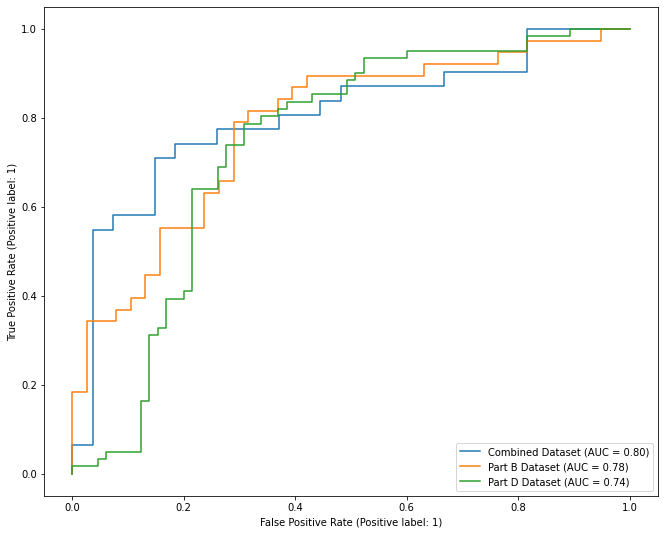

In [28]:
ROC_combined = metrics.plot_roc_curve(tree_rf_combined, X_test_combined, y_test_combined, name='Combined Dataset')
ROC_partb = metrics.plot_roc_curve(tree_rf_b, X_test_b, y_test_b, name='Part B Dataset', ax=ROC_combined.ax_)
ROC_partd = metrics.plot_roc_curve(tree_rf_d, X_test_d, y_test_d, name="Part D Dataset", ax = ROC_combined.ax_)

ROC_combined.figure_.set_size_inches(11,9)
plt.savefig('randforest_ROC.png')

In [29]:
#feature importance B
tree_perm_b = PermutationImportance(tree_rf_b, random_state=1).fit(X_train_b, y_train_b)

print('Random Forest Feature Importances:')
eli5.show_weights(tree_perm_b, feature_names=partb_feature_names)

Random Forest Feature Importances:


Weight,Feature
0.0397 ± 0.0121,Rndrng_Prvdr_Gndr_M
0.0153 ± 0.0125,Tot_Benes_max
0.0109 ± 0.0028,Tot_Benes_mean
0.0108 ± 0.0109,Avg_Sbmtd_Chrg_min
0.0101 ± 0.0044,Tot_Benes_median
0.0101 ± 0.0042,Avg_Mdcr_Pymt_Amt_min
0.0089 ± 0.0034,Avg_Sbmtd_Chrg_sum
0.0082 ± 0.0069,Tot_Srvcs_median
0.0068 ± 0.0044,Tot_Srvcs_min
0.0067 ± 0.0059,Avg_Sbmtd_Chrg_std


In [32]:
#feature importance D
tree_perm_d = PermutationImportance(tree_rf_d, random_state=1).fit(X_train_d, y_train_d)

print('Random Forest Feature Importances D:')
eli5.show_weights(tree_perm_d, feature_names=partd_feature_names)

Random Forest Feature Importances D:


Weight,Feature
0.0215 ± 0.0055,Prscrbr_Type_Nurse Practitioner
0.0202 ± 0.0054,Prscrbr_Type_Internal Medicine
0.0199 ± 0.0052,Tot_30day_Fills_median
0.0170 ± 0.0083,Tot_Drug_Cst_max
0.0170 ± 0.0038,Tot_Drug_Cst_mean
0.0156 ± 0.0062,Tot_Drug_Cst_min
0.0142 ± 0.0126,Tot_Day_Suply_min
0.0140 ± 0.0049,Tot_Drug_Cst_std
0.0136 ± 0.0076,Tot_30day_Fills_max
0.0135 ± 0.0042,Tot_Drug_Cst_median


In [33]:
#feature importance
tree_perm = PermutationImportance(tree_rf_combined, random_state=1).fit(X_train_combined, y_train_combined)

print('Random Forest Feature Importances:')
eli5.show_weights(tree_perm, feature_names=combined_feature_names)

Random Forest Feature Importances:


Weight,Feature
0.0124 ± 0.0110,Tot_Benes_sum_y
0.0097 ± 0.0090,Tot_Drug_Cst_min
0.0091 ± 0.0037,Tot_Day_Suply_std
0.0086 ± 0.0088,Tot_Clms_sum
0.0061 ± 0.0037,Tot_Drug_Cst_mean
0.0061 ± 0.0037,Tot_Day_Suply_mean
0.0061 ± 0.0077,Tot_Drug_Cst_median
0.0054 ± 0.0037,Tot_Day_Suply_max
0.0046 ± 0.0057,Tot_30day_Fills_mean
0.0044 ± 0.0090,Tot_Drug_Cst_sum


In [34]:
#try gradient boosting
clf_b = GradientBoostingClassifier(n_estimators=100, learning_rate=1.0,
     max_depth=1, random_state=0).fit(X_train_b, y_train_b)
clf_d = GradientBoostingClassifier(n_estimators=100, learning_rate=1.0,
     max_depth=1, random_state=0).fit(X_train_d, y_train_d)
clf_combined = GradientBoostingClassifier(n_estimators=100, learning_rate=1.0,
     max_depth=1, random_state=0).fit(X_train_combined, y_train_combined)


[Text(0, 0, 'NOT FRAUD'), Text(0, 1, 'FRAUD')]

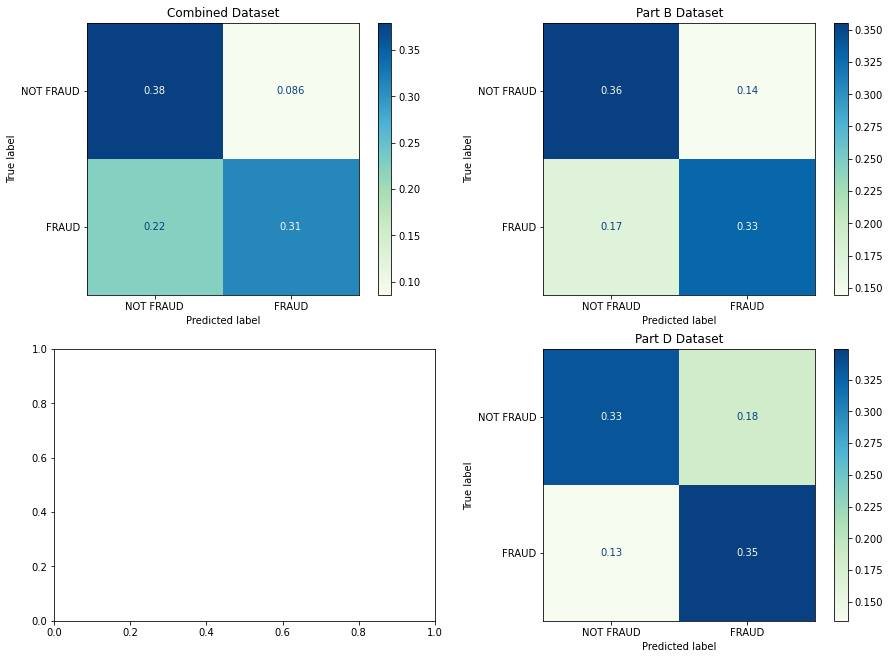

In [35]:
#evaluate performance of gradientboosting
fig, ax = plt.subplots(2,2)
fig.set_size_inches(15, 11)


confusion_matrix_combined = metrics.plot_confusion_matrix(clf_combined, X_test_combined, y_test_combined, cmap= "GnBu", ax = ax[0,0], normalize='all')
ax[0,0].set_title('Combined Dataset')
ax[0,0].set_xticklabels(['NOT FRAUD','FRAUD'])
ax[0,0].set_yticklabels(['NOT FRAUD','FRAUD'])

confusion_matrix_partb = metrics.plot_confusion_matrix(clf_b, X_test_b, y_test_b, cmap= "GnBu", ax = ax[0,1], normalize='all')
ax[0,1].set_title('Part B Dataset')
ax[0,1].set_xticklabels(['NOT FRAUD','FRAUD'])
ax[0,1].set_yticklabels(['NOT FRAUD','FRAUD'])


confusion_matrix_partd = metrics.plot_confusion_matrix(clf_d, X_test_d, y_test_d, cmap= "GnBu", ax = ax[1,1], normalize='all')
ax[1,1].set_title('Part D Dataset')
ax[1,1].set_xticklabels(['NOT FRAUD','FRAUD'])
ax[1,1].set_yticklabels(['NOT FRAUD','FRAUD'])




In [36]:
y_pred_gradient_combined = clf_combined.predict(X_test_combined)
print(f1_score(y_test_combined, y_pred_gradient_combined))

0.6666666666666667
